In [1]:
import matplotlib.pyplot as plt
import numpy as np
import importlib

from mesa.batchrunner import BatchRunner

import src.model

In [2]:
# run this cell to re-import the Model class
importlib.reload(src.model);

# Single run

In [3]:
# setup parameters
time_step = 0.1
n_steps = 10000

model = src.model.Model(
     length=1000,
     lane_width=3.5,
     n_lanes=2,
     flow=0.6,
     max_speed=120,
     car_length=5,
     min_spacing=1,
     car_acc=33 / 10,
     car_dec=33 / 5,
     p_slowdown=0.2,
     time_step=time_step,
     seed=None,
     verbose=0)

# run simulation for `n_steps`
for i in range(n_steps):
    model.step()

Text(0, 0.5, 'Density $k$')

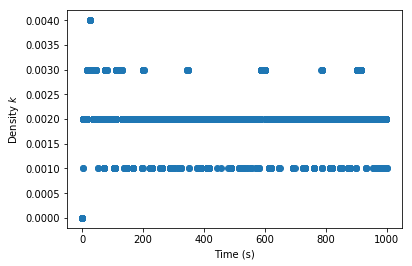

In [4]:
# plot the density over time
df = model.data_collector.get_model_vars_dataframe()
plt.plot(df.index * time_step, df.Density, "o")
plt.xlabel("Time (s)")
plt.ylabel("Density $k$")

# Batch run

Note `BatchRunner` `model_reporters` and `agent_reporters` (unlike the `DataCollector`) won’t collect the data every step of the model, but only at the end of each run. Because of this the following function is used to extract the relevant data from the models datacollector.

In [5]:
def get_density(model, initialisation_steps=0):
    """Extract density from model datacollector.
    
    Parameters
    ----------
    model
    initialisation_steps -- number of initial steps to exclude from the mean.
    """
    # time-evolution of density
    densities = model.data_collector.get_model_vars_dataframe().Density
    # return the mean
    return densities[initialisation_steps:].mean()
    

In [6]:
# setup parameters
n_lanes = [1]
flows = np.linspace(0.1, 2, 10)
n_steps = 1000
initialisation_steps = 500

fixed_params = {
    "length": 1000,
    "lane_width": 3.5,
    #"n_lanes": 2,
    #"flow": 0.6,
    "max_speed": 120,
    "car_length": 5,
    "min_spacing": 1,
    "car_acc": 33 / 10,
    "car_dec": 33 / 5,
    "p_slowdown": 0.2,
    "time_step": 0.1,
    "verbose": 0
}
variable_params = {
    "n_lanes": n_lanes,
    "flow": flows
}

# create and run `BatchRunner`
batch_run = BatchRunner(src.model.Model,
                        fixed_parameters=fixed_params,
                        variable_parameters=variable_params,
                        iterations=5,
                        max_steps=n_steps,
                        model_reporters={
                            "density": lambda x: get_density(x, initialisation_steps)
                        },
                        agent_reporters={},
                        display_progress=True)
batch_run.run_all()

50it [00:01, 27.14it/s]


In [7]:
# get the dataframe and select the relevant columns
df = batch_run.get_model_vars_dataframe()
df = df[["n_lanes", "flow", "density"]]

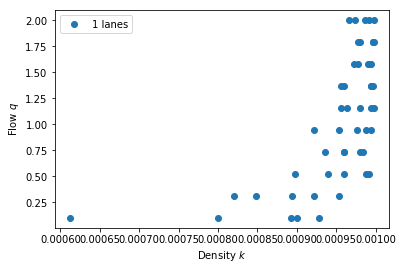

In [8]:
# plot flow rate versus vehicle density 
fig, ax = plt.subplots(1, 1)
for n_lane in n_lanes:
    data = df[df.n_lanes == n_lane]
    ax.plot(data.density, data.flow, "o", label="{} lanes".format(n_lane))

ax.set_xlabel("Density $k$")
ax.set_ylabel("Flow $q$")    
ax.legend()